In [1]:
file_name = "graph_path_planning.ipynb"
import sys
import os
sys.path.insert(0, os.path.abspath(
    os.path.join(os.path.dirname(file_name), '../../src/') ))

from configuration_space_mapping import *
from utils import *
from a_star import a_star
from graph import *
from segment_operations import is_there_shared_point, find_shared_segment

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon as PlottablePoly
from sympy import Polygon, Line, Point
import numpy as np

In [2]:
client_id = connect_2_sim()
test_connection(client_id)

Connected to remote API server
Number of objects in the scene:  43


In [3]:
scene_objects = ['Cuboid_0','Cuboid_1','Cuboid_2',
                 'Cuboid_3','Cuboid_4']
robot_name = './dr20'


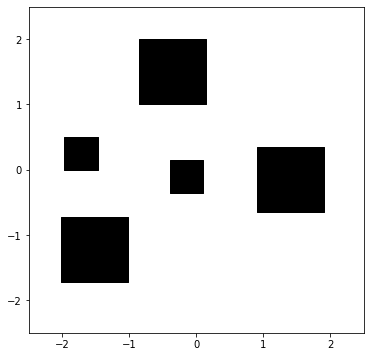

In [4]:
fig, ax = plt.subplots(figsize=(6,6))

obj_points_list = []
obj_plot_polys = []
for obj in scene_objects:
    
    errorCode, objHandl = sim.simxGetObjectHandle(client_id, obj, sim.simx_opmode_blocking)
    error_pos, objPos = sim.simxGetObjectPosition(client_id, objHandl, -1, sim.simx_opmode_blocking)
    error_ang, objAng = sim.simxGetObjectOrientation(client_id, objHandl, -1, sim.simx_opmode_blocking)
    
    objAng = list(reversed(objAng))
    
    points_local = get_bounding_box_corners_local_coordinates(client_id, objHandl)
     
    points_global = map_local_coordinates_to_global_coordinates(points_local, objAng, objPos)
    
    points_poly = [p[:2] for p in points_global]

    poly = np.array(points_poly)
    p = PlottablePoly(poly, facecolor = 'k')
    obj_plot_polys.append(p)
    obj_points_list.append(points_poly)

obj_points_list = np.array(obj_points_list)

p = PatchCollection(obj_plot_polys, color='k')

ax.add_collection(p)

ax.set_xlim([-2.5,2.5])
ax.set_ylim([-2.5,2.5])
plt.show()
plt.close(fig)

In [5]:
line_x_coords = np.sort(obj_points_list[:,:,0].flatten())
line_x_coords = np.array([line_x_coords[i] for i in range(0,len(line_x_coords), 2)])
line_x_coords

array([-2.0249995 , -1.97499979, -1.47499979, -1.0249995 , -0.85000012,
       -0.3999995 ,  0.1000005 ,  0.14999988,  0.89999997,  1.89999997])

In [6]:
obj_poly_list = []
for obj_ps in obj_points_list:
    p1, p2, p3, p4 = map(Point, obj_ps)
    poly = Polygon(p1, p2, p3, p4)
    obj_poly_list.append(poly)

lines_list = []
for x_coord in line_x_coords:   
    p1, p2 = map(Point, [(x_coord,2.5), (x_coord,-2.5)])
    line = Line(p1,p2)
    lines_list.append(line)

i = 1
lines_intersects = []
for line in lines_list:
    print(f'testing line {i}')
    j = 0
    y_intersects = []
    for poly in obj_poly_list:
        print(f'\ttesting poly {j}')
        intersects = poly.intersection(line)
        try:
            points = [p.evalf() for p in intersects]
        except:
            points = [s.points[0].evalf() for s in intersects]
        print('\t', points)
        if len(points) == 1:
            pass
            #poly_ys = [p.evalf()[1] for p in poly.vertices] #to float
            #max_y = max(poly_ys)
            #min_y = min(poly_ys)
            #y_intersects.append(max_y)
            #y_intersects.append(min_y)
        else:
            for p in points:
                y_intersects.append(p[1])
        j += 1
    lines_intersects.append(y_intersects)
    i += 1

testing line 1
	testing poly 0
	 []
	testing poly 1
	 []
	testing poly 2
	 [Point2D(-2.02499950075732, -1.72499953880305)]
	testing poly 3
	 []
	testing poly 4
	 []
testing line 2
	testing poly 0
	 [Point2D(-1.97499978701219, 0.500000361188073)]
	testing poly 1
	 []
	testing poly 2
	 [Point2D(-1.97499978701219, -1.72499953914350), Point2D(-1.97499978701219, -0.724999539143498)]
	testing poly 3
	 []
	testing poly 4
	 []
testing line 3
	testing poly 0
	 [Point2D(-1.47499978701219, 3.64930070856112e-7), Point2D(-1.47499978701219, 0.500000364930071)]
	testing poly 1
	 []
	testing poly 2
	 [Point2D(-1.47499978701219, -1.72499954254801), Point2D(-1.47499978701219, -0.724999542548015)]
	testing poly 3
	 []
	testing poly 4
	 []
testing line 4
	testing poly 0
	 []
	testing poly 1
	 []
	testing poly 2
	 [Point2D(-1.02499950075732, -1.72499954561208), Point2D(-1.02499950075732, -0.724999545612083)]
	testing poly 3
	 []
	testing poly 4
	 []
testing line 5
	testing poly 0
	 []
	testing poly 1
	 [Po

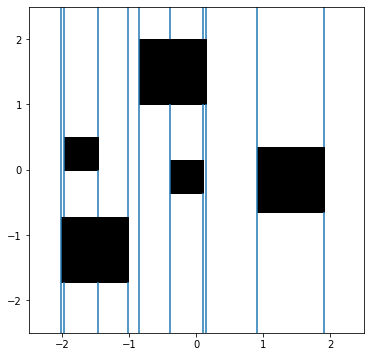

In [7]:
lines_intersects = [sorted(i) for i in lines_intersects]

fig, ax = plt.subplots(figsize=(6,6))

p = PatchCollection(obj_plot_polys, color='k')

ax.add_collection(p)

ax.set_xlim([-2.5,2.5])
ax.set_ylim([-2.5,2.5])

for x, ys in zip(line_x_coords, lines_intersects):
    y_min = -2.5
    for i in range(0, len(ys)-1, 2):
        plt.vlines(x, y_min, float(ys[i]))
        y_min = float(ys[i+1])
    plt.vlines(x, y_min, 2.5)

plt.show()

In [8]:
lines_intersects

[[],
 [-1.72499953914350, -0.724999539143498],
 [-1.72499954254801,
  -0.724999542548015,
  3.64930070856112e-7,
  0.500000364930071],
 [-1.72499954561208, -0.724999545612083],
 [],
 [0.999999396106158, 1.99999939610616],
 [-0.349999621636757, 0.150000378363243, 0.999999390585735, 1.99999939058574],
 [0.999999390033699, 1.99999939003370],
 [],
 [-0.649999857338808, 0.350000142661190]]

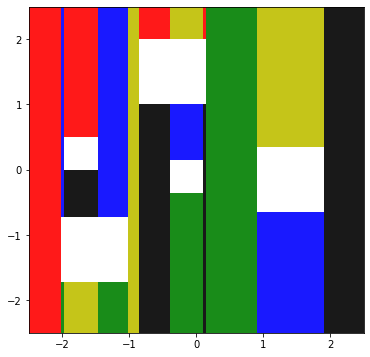

In [9]:
cells_points = []
prev_x = -2.5
for x, ys in zip(line_x_coords, lines_intersects):
    x_min, x_max = prev_x, x
    y_min, y_max = -2.5, 2.5
    
    if len(ys) > 0:
        for i in range(0, len(ys)-1, 2):
            y_max = ys[i]
            cell = [[x_max, y_max], [x_min, y_max], [x_min, y_min], [x_max, y_min]]
            cells_points.append(np.array(cell))
            y_min = ys[i+1]
            y_max = 2.5
        cell = [[x_max, y_max], [x_min, y_max], [x_min, y_min], [x_max, y_min]]
        cells_points.append(np.array(cell))
    else:
        cell = [[x_max, y_max], [x_min, y_max], [x_min, y_min], [x_max, y_min]]
        cells_points.append(np.array(cell))
    prev_x = x

x_min, x_max = x, 2.5
y_min, y_max = -2.5, 2.5
cell = [[x_max, y_max], [x_min, y_max], [x_min, y_min], [x_max, y_min]]
cells_points.append(np.array(cell))


cells_plottable = []
for cell in cells_points:
    p = PlottablePoly(cell, facecolor = 'k')
    cells_plottable.append(p)

import matplotlib.colors
colors = values = np.array([i%5 for i in range(len(cells_plottable))])
cmap = matplotlib.colors.ListedColormap(['r', 'g', 'b', 'y', 'k'])
p = PatchCollection(cells_plottable, cmap=cmap, alpha=0.9)
p.set_array(colors)

fig, ax = plt.subplots(figsize=(6,6))
ax.add_collection(p)

ax.set_xlim([-2.5,2.5])
ax.set_ylim([-2.5,2.5])
plt.show()
plt.close(fig)

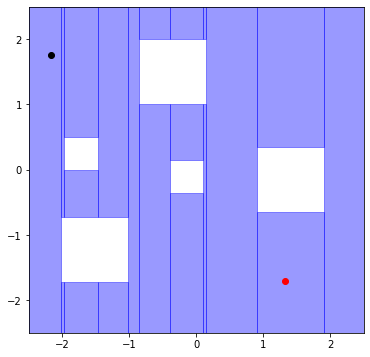

In [10]:
fig, ax = plt.subplots(figsize=(6,6))
p = PatchCollection(cells_plottable, alpha=0.4, color='b')

errorCode, roboHandl = sim.simxGetObjectHandle(client_id, robot_name, sim.simx_opmode_blocking)
error_pos, roboPos = sim.simxGetObjectPosition(client_id, roboHandl, -1, sim.simx_opmode_blocking)
errorCode, goalHandl = sim.simxGetObjectHandle(client_id, './Goal', sim.simx_opmode_blocking)
error_pos, goalPos = sim.simxGetObjectPosition(client_id, goalHandl, -1, sim.simx_opmode_blocking)

ax.add_collection(p)
plt.scatter(roboPos[0], roboPos[1], color='k')
plt.scatter(goalPos[0], goalPos[1], color='r')

ax.set_xlim([-2.5,2.5])
ax.set_ylim([-2.5,2.5])
plt.show()
plt.close(fig)

In [11]:
def square_from_array(obj_points):
    p1, p2, p3, p4 = map(Point, obj_points)
    poly = Polygon(p1, p2, p3, p4)
    return poly

cells_poly = []
for cell in cells_points:
    p = square_from_array(cell)
    cells_poly.append(p)

In [12]:
#get robot and goal cell
robo_point = Point(roboPos[:2])
goal_point = Point(goalPos[:2])

robo_cell = -1
goal_cell = -1
for i, cell in zip(range(len(cells_poly)), cells_poly):
    if cell.encloses_point(goal_point):
        goal_cell = i
    elif cell.encloses_point(robo_point):
        robo_cell = i
                   
robo_cell, goal_cell

(0, 17)

In [13]:
connections = []
print('initiating graph')
for i in range(len(cells_poly)):
    #print(f'testing cell {i}:')
    for j in range(i, len(cells_poly)):
        distance = cells_poly[i].distance(cells_poly[j]).evalf()
        if distance < 0.000001:
            connections.append((f'{i}', f'{j}'))
            #print(f'\t neighbour to {j}')
connections

initiating graph


/home/pudimi/anaconda3/lib/python3.8/site-packages/sympy/geometry/polygon.py:1136: UserWarning: Polygons may intersect producing erroneous output
  warnings.warn("Polygons may intersect producing erroneous output")


[('0', '1'),
 ('0', '2'),
 ('1', '3'),
 ('2', '4'),
 ('2', '5'),
 ('3', '6'),
 ('4', '7'),
 ('5', '7'),
 ('6', '8'),
 ('7', '8'),
 ('8', '9'),
 ('8', '10'),
 ('9', '11'),
 ('9', '12'),
 ('10', '13'),
 ('11', '14'),
 ('12', '14'),
 ('13', '15'),
 ('14', '16'),
 ('15', '16'),
 ('16', '17'),
 ('16', '18'),
 ('17', '19'),
 ('18', '19')]

In [14]:
errorCode, roboHandl = sim.simxGetObjectHandle(client_id, robot_name, sim.simx_opmode_blocking)
error_pos, roboPos = sim.simxGetObjectPosition(client_id, roboHandl, -1, sim.simx_opmode_blocking)
errorCode, goalHandl = sim.simxGetObjectHandle(client_id, './Goal', sim.simx_opmode_blocking)
error_pos, goalPos = sim.simxGetObjectPosition(client_id, goalHandl, -1, sim.simx_opmode_blocking)

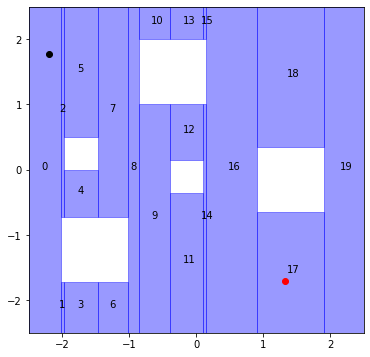

In [15]:
fig, ax = plt.subplots(figsize=(6,6))

p = PatchCollection(cells_plottable, alpha=0.4, color='b')
ax.add_collection(p)

plt.scatter(roboPos[0], roboPos[1], color='k')
plt.scatter(goalPos[0], goalPos[1], color='r')

i=0
for cell in cells_poly:
    centr = cell.centroid.evalf()
    plt.text(centr[0] - 0.05, centr[1], f'{i}')
    i += 1

ax.set_xlim([-2.5,2.5])
ax.set_ylim([-2.5,2.5])
plt.show()
plt.close(fig)

# A* Algorithm

Ok, so far we have the connectivity graph implemented as a list of tuples (variable `connections`). From this point on the A* algorithm will be implemented

## Graph and its Weights

Here we will compute the graph as a dict of lists. It will capture the connectivity of it.

We will also compute `g(N)` or the weights associated with the arcs. This is calculated as the Euclidian distance between two cells' centroids.

The heuristic function `h(N)`is estimated as the Euclidian distance between the cell's centroids and the target point.

This approach has two effects:
- `g(N)` and its local effect: it will make a path out of nearby cells. That is, the A* will tend to move between closer cells 
- `h(N)` and its global effect: it will make a path out of cells closer and closer to the target. That is, the A* will pull the path closer and closer to the target.

In [16]:
graph_connections = {}
g_N = {}
h_N = {}
print('initializing graph as dict')
for i in range(len(cells_poly)):
    if i not in graph_connections.keys():
        graph_connections[i] = []
    if i not in g_N.keys():
        g_N[i] = []
    if i not in h_N.keys():
        h_N[i] = cells_poly[i].centroid.distance(goal_point).evalf()
    for j in range(i, len(cells_poly)):
        if j not in graph_connections.keys():
            #print(f'creating key {j}')
            graph_connections[j] = []
        if j not in g_N.keys():
            g_N[j] = []
        distance = cells_poly[i].distance(cells_poly[j]).evalf()
        cost = cells_poly[i].centroid.distance(cells_poly[j].centroid).evalf()
        if distance < 0.000001:
            graph_connections[i].append(j)
            graph_connections[j].append(i)
            g_N[i].append(cost)
            g_N[j].append(cost)
            #print(f'\t neighbour to {j}')

graph_connections

initializing graph as dict


{0: [1, 2],
 1: [0, 3],
 2: [0, 4, 5],
 3: [1, 6],
 4: [2, 7],
 5: [2, 7],
 6: [3, 8],
 7: [4, 5, 8],
 8: [6, 7, 9, 10],
 9: [8, 11, 12],
 10: [8, 13],
 11: [9, 14],
 12: [9, 14],
 13: [10, 15],
 14: [11, 12, 16],
 15: [13, 16],
 16: [14, 15, 17, 18],
 17: [16, 19],
 18: [16, 19],
 19: [17, 18]}

In [17]:
g_N

{0: [2.12874648146509, 0.925506869190883],
 1: [2.12874648146509, 0.274999856872565],
 2: [0.925506869190883, 1.27989236632344, 0.671402347720794],
 3: [0.274999856872565, 0.475000143127435],
 4: [1.27989236632344, 1.33720779087562],
 5: [0.671402347720794, 0.775100852262565],
 6: [0.475000143127435, 2.13548857095185],
 7: [1.33720779087562, 0.775100852262565, 0.940910622657500],
 8: [2.13548857095185, 0.940910622657500, 0.812500278329099, 2.27159743145729],
 9: [0.812500278329099, 0.825378476342810, 1.40756910531954],
 10: [2.27159743145729, 0.475000307613869],
 11: [0.825378476342810, 0.728868413151694],
 12: [1.40756910531954, 1.35323698326466],
 13: [0.475000307613869, 0.274999692386131],
 14: [0.728868413151694, 1.35323698326466, 0.850000145214463],
 15: [0.274999692386131, 2.28527863005055],
 16: [0.850000145214463, 2.28527863005055, 1.80173523385733, 1.67219923481219],
 17: [1.80173523385733, 1.76652902573442],
 18: [1.67219923481219, 1.63420476891538],
 19: [1.76652902573442, 1

In [18]:
h_N

{0: 3.96990595572144,
 1: 3.35048927373924,
 2: 4.21316728977168,
 3: 3.07776777602303,
 4: 3.33037612052884,
 5: 4.42068978911002,
 6: 2.60783032760401,
 7: 3.65044918281652,
 8: 2.83000078009350,
 9: 2.16910074582423,
 10: 4.40511011093305,
 11: 1.50041604942758,
 12: 2.71131830089157,
 13: 4.21641072575273,
 14: 1.53052227407740,
 15: 4.12825574027809,
 16: 1.87882925113736,
 17: 0.145773716698999,
 18: 3.12589975208014,
 19: 1.91196873693555}

## A* Algorithm

In [19]:
robo_cell, goal_cell

(0, 17)

In [20]:
graph_connections[robo_cell]

[1, 2]

In [21]:
h_N[robo_cell]

3.96990595572144

In [22]:
g_N[robo_cell]

[2.12874648146509, 0.925506869190883]

In [23]:
type(cells_poly[0])

sympy.geometry.polygon.Polygon

In [79]:
path = a_star(robo_cell, goal_cell, graph_connections, g_N, h_N,cells_poly)
path[2] = 5
path

path found


[0, 2, 5, 7, 8, 9, 11, 14, 16, 17]

# Trying to find an way of making the robot move

In [25]:
segmento_encontrado = find_shared_segment(cells_poly[13], cells_poly[15])
if segmento_encontrado != -1:
    print(segmento_encontrado.midpoint.evalf())
else:
    print('no segment found')

Point2D(0.100000497208729, 2.24999969501685)


In [26]:
path

[0, 2, 4, 7, 8, 9, 11, 14, 16, 17]

In [30]:
roboPos

[-2.199040651321411, 1.7671772241592407, 0.15101270377635956]

In [51]:
()

Point2D(-1.19904065132141, 1.76717722415924)

In [93]:
point = Point(roboPos[0], roboPos[1])
points_to_go = []

for i in path[1:]:
    point_center = cells_poly[i].centroid
    line = Line(point, point_center)
    cell_intersect = cells_poly[i].intersect(line)
    point = cell_intersect.args[0].evalf()
    
    points_to_go.append([point[0], point[1]])
    
points_to_go.append([goalPos[0], goalPos[1]])

In [94]:
points_to_go

[[-2.02499950075732, 0.997989014727446],
 [-1.97499978701219, 1.08165714350794],
 [-1.47499978701219, 0.947755848346502],
 [-1.02499950075732, 0.154285298001702],
 [-0.850000118019009, -0.241338562783844],
 [-0.399999502791271, -1.00226402234716],
 [0.100000497208729, -0.762012722182138],
 [0.149999881980991, -0.672365149298713],
 [0.899999970683028, -1.21394604254210],
 [1.3249999284744263, -1.6999998092651367]]

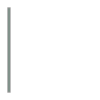

In [86]:
cells_poly[2]